# Model Using ResNet50

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import os
import logging
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


### === Path ===

In [4]:
main_dir = r"/content/drive/MyDrive/CapstoneBangkit/dataset"
train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'val')
test_dir = os.path.join(main_dir, 'test')

### === Preprocessing ===

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 7176 images belonging to 2 classes.
Found 1626 images belonging to 2 classes.
Found 173 images belonging to 2 classes.


### === Load ResNet50 ===

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

 ### === Custom Layers and fine-tuning ===

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

### === Build model ===

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

### === Training callback ===

In [ ]:
class MonitorTraining(tf.keras.callbacks.Callback):
    def __init__(self, patience=3, overfit_gap=0.2, underfit_threshold=1.0):
        super(MonitorTraining, self).__init__()
        self.patience = patience
        self.overfit_gap = overfit_gap
        self.underfit_threshold = underfit_threshold
        self.wait = 0
        self.best_val_loss = float('inf')
        self.reason = None

    def on_epoch_end(self, epoch, logs=None):
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # underfit
        if train_loss > self.underfit_threshold:
            self.reason = (
                f"\nTraining is stopped due to underfit at epoch {epoch}. \n"
                f"Train_loss: {train_loss:.4f} > Underfit threshold: {self.underfit_threshold:.4f}")
            print(self.reason)
            self.model.stop_training = True
            return

        # overfit
        loss_gap = abs(val_loss - train_loss)
        if loss_gap > self.overfit_gap:
            self.wait += 1
            if self.wait >= self.patience:
                self.reason = (
                    f"\nTraining is stopped due to overfit at epoch {epoch}.\n"
                    f"Loss gap: {loss_gap:.4f} > Overfit gap: {self.overfit_gap:.4f}\n"
                    f"For {self.patience} consecutive epochs."
                )
                print(self.reason)
                self.model.stop_training = True
        else:
            # Reset counter
            self.wait = 0
            self.best_val_loss = min(self.best_val_loss, val_loss)

    def on_train_end(self, logs=None):
        # best fit
        if self.reason is None:
            print("\nTaining is completed without overfit or underfit detection.")

In [11]:
# Callback MonitorTraining
monitor_training = MonitorTraining(
    patience=4,
    overfit_gap=0.05,
    underfit_threshold=1.0
)

### === Compile model ===

In [12]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### === Logging training info ===

In [13]:
logging.basicConfig(filename='training_log.txt, level=logging.INFO')

### === Training model ===

In [14]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[monitor_training]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 1652s 7s/step - accuracy: 0.6536 - loss: 0.6299 - val_accuracy: 0.4803 - val_loss: 0.7915
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 100s 334ms/step - accuracy: 0.9457 - loss: 0.1677 - val_accuracy: 0.5726 - val_loss: 0.8794
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 345ms/step - accuracy: 0.9873 - loss: 0.0471 - val_accuracy: 0.8733 - val_loss: 0.2962
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 345ms/step - accuracy: 0.9928 - loss: 0.0232 - val_accuracy: 0.9791 - val_loss: 0.0682
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 343ms/step - accuracy: 0.9967 - loss: 0.0135 - val_accuracy: 0.9945 - val_loss: 0.0185
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 88s 386ms/step - accuracy: 0.9990 - loss: 0.0072 - val_accuracy: 0.9951 - val_loss: 0.0151
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 79s 342ms/step - accuracy: 0.9986 - loss: 0.0054 - val_accuracy: 0.9957 - val_loss: 0.0181
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - accuracy: 0.9984 - loss: 0.0062 - val

### === Plot accuracy ===

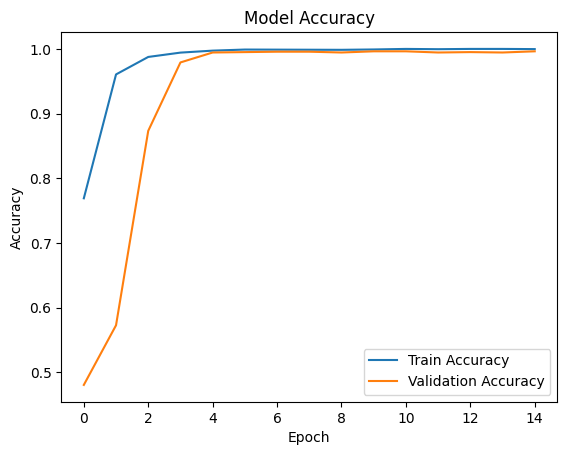

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### === Plot loss ===

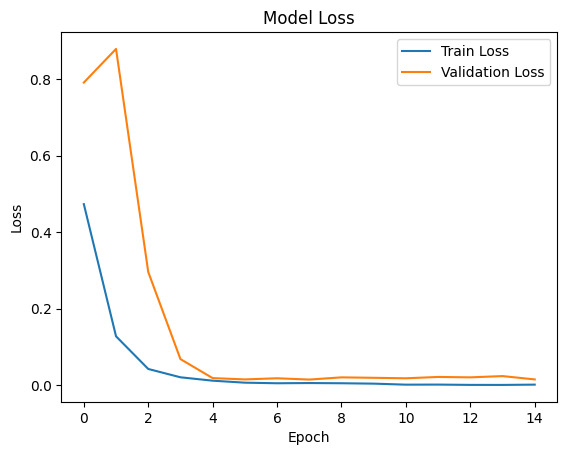

In [16]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### === Save model ===

In [17]:
model.save('model.h5')
print("Model saved as model.h5")

Model saved as model.h5


### === Evaluate model on test set ===

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.9910 - loss: 0.0097
Test Loss: 0.0182, Test Accuracy: 0.9827


In [19]:
prediction = model.predict(test_generator)
predicted_class_indices = tf.argmax(prediction, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 748ms/step


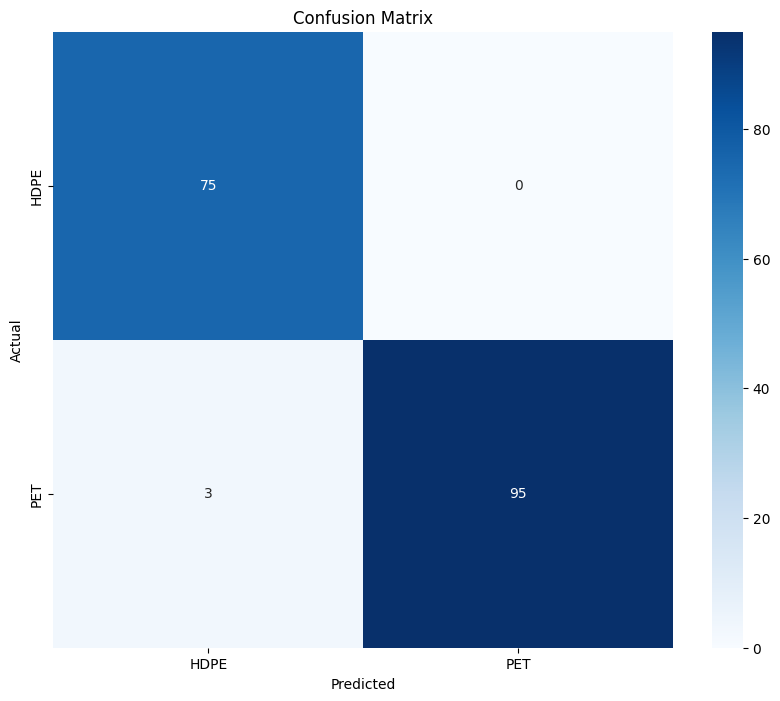

In [20]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_class_indices)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
report = classification_report(true_classes, predicted_class_indices, target_names=class_labels)
print(report)
logging.info("Test Loss: %.4f, Test Accuracy: %.4f".format(test_loss, test_acc))
logging.info("Classification Report: \n{}" + report)

              precision    recall  f1-score   support

        HDPE       0.96      1.00      0.98        75
         PET       1.00      0.97      0.98        98

    accuracy                           0.98       173
   macro avg       0.98      0.98      0.98       173
weighted avg       0.98      0.98      0.98       173

